# Microstates Tutorial

The code used in this script is adapted from https://github.com/wmvanvliet/mne_microstates

This method takes in preprocessed MEG data in .fif file format. The only requiered parameter is the number of states (n_states). The method returns topography maps of each state and the microstate segmentation of the recording. 


In [1]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import mne
import mne_microstates

In [2]:
# Loading MEG data
raw = mne.io.read_raw_fif('meg_data_raw.fif')
data = raw.get_data()

data.shape # data size is (channels x time points)

Opening raw data file meg_data_raw.fif...
Isotrak not found
    Range : 0 ... 300000 =      0.000 ...   300.000 secs
Ready.


(270, 300001)

In [3]:
# Define number of microstates

n_states = 4

In [4]:
# Clustering data into microstates

maps, seg = mne_microstates.segment(data, n_states=n_states)

Finding 4 microstates, using 10 random intitializations
Converged at 80 iterations.
GEV of found microstates: 0.364995
Converged at 63 iterations.
GEV of found microstates: 0.364929
Converged at 42 iterations.
GEV of found microstates: 0.363289
Converged at 91 iterations.
GEV of found microstates: 0.365201
Converged at 57 iterations.
GEV of found microstates: 0.364920
Converged at 52 iterations.
GEV of found microstates: 0.364286
Converged at 112 iterations.
GEV of found microstates: 0.362913
Converged at 77 iterations.
GEV of found microstates: 0.365254
Converged at 72 iterations.
GEV of found microstates: 0.365189
Converged at 67 iterations.
GEV of found microstates: 0.364878


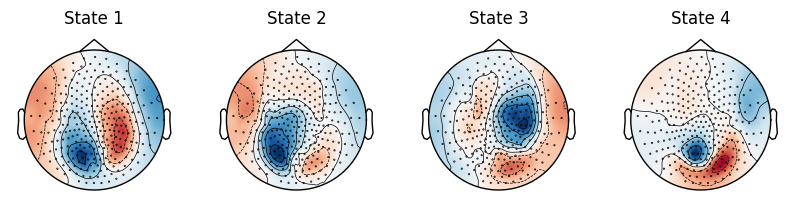

In [5]:
# Plotting microstate maps

ctf_layout = sio.loadmat('CTF_layout.mat') # load channel layout for plotting 

fig, axes = plt.subplots(1, n_states, figsize=(10, 4))

for i, (ax, m) in enumerate(zip(axes.flatten(), maps)):
        mne.viz.plot_topomap(m, 
                             pos = ctf_layout['pos'], 
                             ch_type='meg', 
                             sphere=0.5,
                             cmap='RdBu',
                             image_interp = 'cubic',
                             axes=ax, show=False)
        ax.set_title('State %d' % (i+1))

In [6]:
alp = [np.eye(n_states)[state] for state in seg]
    
# calculating WELCH state spectra & coherence
from osl_dynamics.analysis import spectral
f, psd, coh, w = spectral.welch_spectra(
    data= data.T,
    alpha =  np.array(alp),
    sampling_frequency =1000,
    frequency_range=[1,50],
    return_weights = True,
    n_jobs=1,
)

2025-03-27 16:22:58 INFO osl-dynamics [spectral.py:246:welch_spectra]: Calculating spectra


In [7]:
av_psd = np.mean(psd, axis=1)
print(av_psd.shape)

(4, 98)


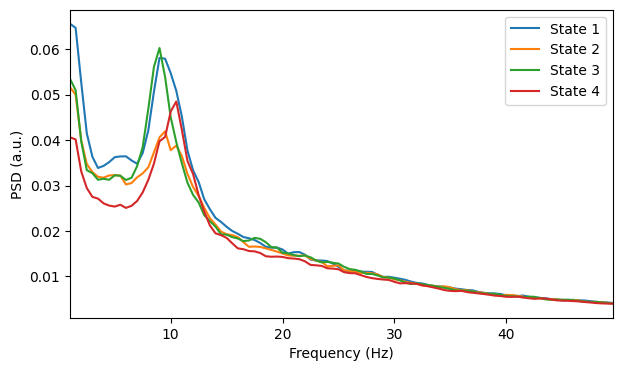

In [8]:
# Plot
from osl_dynamics.utils import plotting

fig, ax = plotting.plot_line(
    [f] * n_states,
    av_psd,
    labels=[f"State {i}" for i in range(1, n_states + 1)],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    x_range=[f[0], f[-1]],
)